In [1]:
import sys
from pathlib import Path

import h5py as h5
import numpy as np
import pandas as pd
import xarray as xr

sys.path.append('../lib')
from storage import get_storage_functions, quantize
from local_paths import preproc_dir, analysis_dir, database_dir
from self_consistency import find_return_fixations, pairwise_self_consistency

# Set parameters

In [2]:
#============================================================================
# session
#============================================================================
sess_name = 'sess_name'


#============================================================================
# response windows
#============================================================================
t_win = 200


#============================================================================
# return fixation selection
#============================================================================
return_thres_opts = (1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16)
exclude_same_trial = True

# "decorrelate" return fixations:
#   sub-select only return pairs where the non-return fixations
#   (e.g., "prev" for "curr return") are this far apart
min_sep      =   4  # dva; only consider saccades at least this large
min_sep_win  = 100


#============================================================================
# paths
#============================================================================
proc_dir = preproc_dir
output_dir = analysis_dir + 'rsc_precision'

latency_path = database_dir + 'per_unit_latency-fix_on.csv.gz'

In [3]:
# Parameters
sess_name = "Pa210201"
output_dir = "../test_results"


# Check prereqs and params

In [4]:
proc_path = Path(proc_dir) / (sess_name + '-proc.h5')
print('Loading shared processing from', proc_path)
proc_path = proc_path.expanduser()
assert proc_path.is_file()

rasters_path = Path(proc_dir) / (sess_name + '-rasters.nwb')
print('Loading rasters from', rasters_path)
rasters_path = rasters_path.expanduser()
assert rasters_path.is_file()

print('Using per-unit latency from', latency_path)
latency_path = Path(latency_path).expanduser()
assert latency_path.is_file()

output_dir = Path(output_dir)
assert output_dir.expanduser().is_dir()
output_path = output_dir / (sess_name + '.h5')
print('Saving results to', output_path)
output_path = output_path.expanduser()

Loading shared processing from ../test_data/Pa210201-proc.h5
Loading rasters from ../test_data/Pa210201-rasters.nwb
Using per-unit latency from ../db/per_unit_latency-fix_on.csv.gz
Saving results to ../test_results/Pa210201.h5


In [5]:
analysis_name = 'rsc_precision'

if output_path.is_file():
    with h5.File(output_path, 'r') as f:
        try:
            if f[f'progress_report/{analysis_name}/all_done'][()].item():
                raise RuntimeError(f'{sess_name} has already been processed')
        except KeyError:
            pass

# Save config

In [6]:
with h5.File(proc_path, 'r') as f:
    random_seed = f['config/default_random_seed'][()]
    sacc_sel = f['saccade_selection/fixation_indices'][()]
    unit_names = f['unit_selection/simple'][()].astype(str)
fix_df = pd.read_hdf(proc_path, 'fixation_dataframe', 'r')

print('random_seed:', random_seed)

random_seed: 775418045


In [7]:
save_results, add_attr_to_dset, check_equals_saved, link_dsets, copy_group = \
    get_storage_functions(output_path)

In [8]:
group = analysis_name + '/config/'
save_results(group+'random_seed', random_seed)
save_results(f'{group}/return_thres_options', np.array(return_thres_opts), attrs=dict(unit='dva'))
save_results(f'{group}/exclude_same_trial', exclude_same_trial)

group = analysis_name + '/config/time_windows/'
save_results(group+'t_win', t_win)
add_attr_to_dset(group, attrs=dict(unit='ms'))

group = analysis_name + '/config/return_criterion/'
save_results(f'{group}/return_thres_options', np.array(return_thres_opts), attrs=dict(unit='dva'))
save_results(group+'min_sep', min_sep, attrs=dict(unit='dva'))
save_results(group+'min_sep_win', min_sep_win, attrs=dict(unit='ms'))

save_results(analysis_name+'/saccade_selection', sacc_sel)

# Find return pairs

In [9]:
def decorrelate_return_pairs(return_pairs, cond='current', min_sep=min_sep, min_sep_win=min_sep_win, fix_df=fix_df):
    decorr_win = 'current' if cond == 'previous' else 'previous'

    iind_tr = fix_df.index.names.index('Trial')
    iind_fix = fix_df.index.names.index('Fixation')

    min_seps = np.full(len(return_pairs), np.inf)

    for i, (i0_, i1_) in enumerate(return_pairs):
        i0, i1 = sacc_sel[1,[i0_,i1_]]
        itr0, itr1 = fix_df.index.get_level_values(iind_tr)[[i0,i1]]
        tr0_fixs = fix_df.loc[(itr0, slice(None))]
        tr1_fixs = fix_df.loc[(itr1, slice(None))]

        # find any relevant fixations within min_sep window
        if decorr_win == 'current':
            ifix0, ifix1 = fix_df.index.get_level_values(iind_fix)[[i0,i1]]
            t0, t1 = fix_df.iloc[[i0,i1]]['Time'].values

            m0 = tr0_fixs.index >= ifix0
            if not m0.any(): continue
            m0[m0] = tr0_fixs.loc[m0, 'Time'] <= (t0 + min_sep_win)
            if not m0.any(): continue

            m1 = tr1_fixs.index >= ifix1
            if not m1.any(): continue
            m1[m1] = tr1_fixs.loc[m1, 'Time'] <= (t1 + min_sep_win)
            if not m1.any(): continue

        else:
            i0, i1 = sacc_sel[0,[i0_,i1_]]
            ifix0, ifix1 = fix_df.index.get_level_values(iind_fix)[[i0,i1]]
            t0, t1 = fix_df.iloc[[i0,i1]]['End time'].values

            m0 = tr0_fixs.index <= ifix0
            if not m0.any(): continue
            m0[m0] = tr0_fixs.loc[m0, 'End time'].values > (t0 - min_sep_win)
            if not m0.any(): continue

            m1 = tr1_fixs.index <= ifix1
            if not m1.any(): continue
            m1[m1] = tr1_fixs.loc[m1, 'End time'].values > (t1 - min_sep_win)
            if not m1.any(): continue

        pwd = np.linalg.norm(
            tr0_fixs.loc[m0, ['Relative X', 'Relative Y']].values[:,None,:]
            - tr1_fixs.loc[m1, ['Relative X', 'Relative Y']].values[None,:,:],
            axis=-1)
        min_seps[i] = pwd.min()

    return return_pairs[min_seps >= min_sep]

In [10]:
df_ = fix_df.iloc[sacc_sel[1]]
imids = np.array([f'{v0}/{v1}' for v0, v1 in df_[['Image subdir', 'Image filename']].values])
posns = df_[['Relative X', 'Relative Y']].values


# first, find returns at the highst threshold; this is the superset of return pairs at all thresholds
return_thres = np.max(return_thres_opts)
return_pairs = find_return_fixations(imids, posns, thres_deg=return_thres)
print(f'return_thres: 2^{np.log2(return_thres):.1f}', end=';\t')
print('return pairs:', return_pairs.shape, end=';\t')

if min_sep > 0:
    return_pairs = decorrelate_return_pairs(return_pairs)
    print(f'decorrelated:', return_pairs.shape, end=';\t')

if exclude_same_trial:
    fix_itrs = fix_df.index.get_level_values(fix_df.index.names.index('Trial')).values[sacc_sel[1]]
    m = fix_itrs[return_pairs[:,0]] != fix_itrs[return_pairs[:,1]]
    return_pairs = return_pairs[m]
    print('excluded same-trial:', return_pairs.shape, end='')

print()
all_return_pairs = return_pairs
pwd = np.linalg.norm(posns[return_pairs[:,0]] - posns[return_pairs[:,1]], axis=1)


# next, subselect pairs per threshold
bycond_return_pairs = {}
bycond_pairs_subsel = {}
for return_thres in return_thres_opts:
    m = pwd <= return_thres
    k = str(return_thres)
    bycond_return_pairs[k] = return_pairs[m]
    bycond_pairs_subsel[k] = m

return_thres: 2^4.0;	return pairs: (13847, 2);	

decorrelated: (8787, 2);	excluded same-trial: (4843, 2)


In [11]:
save_results(analysis_name+'/all_return_pairs', all_return_pairs)

group = analysis_name + '/return_pairs_subset/'
for cond, subsel in bycond_pairs_subsel.items():
    save_results(group+cond, subsel)

# Get fixation onset-aligned responses uaing latency per unit

In [12]:
with h5.File(rasters_path, 'r') as f:
    all_unit_names = f['processing/ecephys/unit_names/unit_name'][()].astype(str)
    all_unit_names = list(all_unit_names)
    sel_ = np.array([all_unit_names.index(n) for n in unit_names])
    rasters = f['processing/ecephys/rasters/data'][()][:,sel_]

In [13]:
lat_df = pd.read_csv(latency_path).set_index('Session').loc[[sess_name]].set_index('Name')
m = pd.Series(unit_names).isin(lat_df.index)
assert m.all(), f'missing latency value for {(~m).sum()} of {m.size} units'
assert not lat_df.index.has_duplicates

lat_df = lat_df.loc[unit_names].reset_index()
assert len(lat_df) == len(unit_names)
lat_df['Index'] = np.arange(len(lat_df))
lat_df['Latency'] = np.clip(lat_df['Latency'], 40, None)
print('Num units using RF fit from each source:')
print('\t' + '\n\t'.join(str(lat_df.groupby('Source').count()['Latency']).split('\n')[:-1]))

Num units using RF fit from each source:
	Source
	Array                 29
	Array, across sess    40
	Channel               11
	Unit                  12


In [14]:
resps = np.empty((sacc_sel.shape[1], rasters.shape[1]), dtype=np.float32)
t_win_ = np.array([0, t_win])
lat_groups = [(dt, df_['Index'].values) for dt, df_ in lat_df.groupby('Latency')]
for i, t in enumerate(fix_df.iloc[sacc_sel[1]]['Time'].values):
    for dt, usel in lat_groups:
        s = slice(*np.round(t+dt+t_win_).astype(int))
        resps[i,usel] = rasters[s,usel].mean(0)

resps.shape, resps.dtype

((4037, 92), dtype('float32'))

In [15]:
lat_df.to_hdf(output_path, analysis_name+'/latency_per_unit', mode='a', format='table', complevel=9, complib='zlib')

# Calculate return self-consistency (one-point)

In [16]:
coords = (('unit', unit_names),)

bycond_rsc_ds = {}
for cond, pairs in bycond_return_pairs.items():
    pairs = bycond_return_pairs[cond]
    if len(pairs) > 1:
        ds = pairwise_self_consistency(
            pairs=pairs, resps=resps,
            n_bootstraps=0, n_permutations=0,
            random_seed=random_seed,
            coords=coords)
        ds = ds.assign(dict(n_pairs=len(pairs)))
        bycond_rsc_ds[cond] = ds

In [17]:
# concat datasets along new dimension
ks = np.array(list(bycond_rsc_ds.keys()))
if len(ks):
    idc = np.array(list(map(float, ks)))
    so = np.argsort(idc)
    idc = idc[so]
    ks = ks[so]
    dim = pd.Index(data=idc, name='return_thres')
    dataset = xr.concat([bycond_rsc_ds[k] for k in ks], dim, coords='all')
    dataset.attrs = {}
else:
    dataset = None

In [18]:
loc = analysis_name + '/data'

if dataset is not None:
    q = lambda x: quantize(x, 3)
    compr = dict(zlib=True, complevel=9)
    k = 'sample'
    dataset = dataset.assign({k: q(dataset.data_vars[k])})
    encoding = {
        k: dict(chunksizes=v.shape, **compr)
        for k, v in dataset.data_vars.items()
        if v.size}
    dataset.to_netcdf(
        output_path, group=loc, mode='a',
        engine='h5netcdf', encoding=encoding)
else:
    save_results(loc, h5.Empty('f'))

# Wrap up

In [19]:
save_results(f'progress_report/{analysis_name}/all_done', True)

In [20]:
%load_ext watermark
%watermark
%watermark -vm --iversions -rbg

Last updated: 2024-02-18T14:20:43.826901-05:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Git hash: b0bb10f45dee065cc3af96fe224326b883d27431

Git repo: https://github.com/willwx/free_viewing_staging.git

Git branch: master

sys   : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
pandas: 2.0.1
xarray: 2023.4.2
numpy : 1.24.3
h5py  : 3.8.0



# Plots

In [21]:
import matplotlib.pyplot as plt

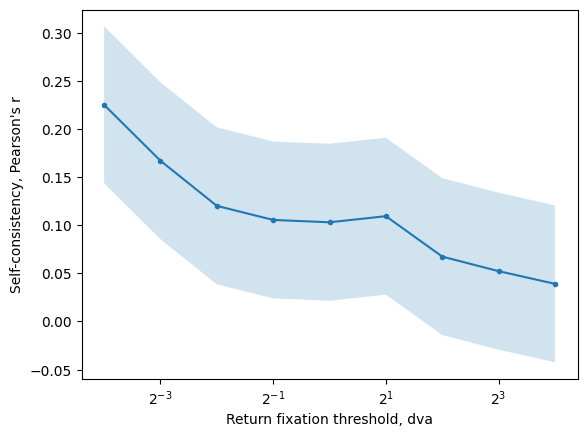

In [22]:
if dataset is not None:
    vs = dataset['sample'].values
    m = np.nanmedian(vs, axis=1)
    s = np.nanmedian(np.abs(vs - m[:,None]))
    x = dataset['return_thres'].values
    plt.plot(x, m, '.-')
    plt.fill_between(x, m-s, m+s, alpha=0.2);
    plt.xscale('log', base=2)
    plt.xlabel('Return fixation threshold, dva')
    plt.ylabel('Self-consistency, Pearson\'s r')

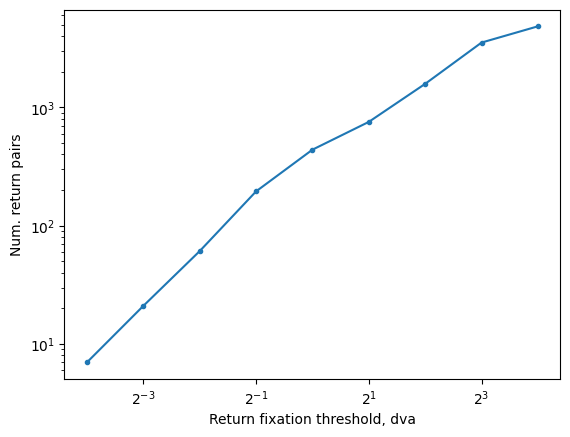

In [23]:
if dataset is not None:
    m = dataset['n_pairs'].values
    x = dataset['return_thres'].values
    plt.plot(x, m, '.-')
    plt.xscale('log', base=2)
    plt.yscale('log')
    plt.xlabel('Return fixation threshold, dva')
    plt.ylabel('Num. return pairs')